
# **Dataset Information|**

Outputs:

[G C B A]

The second part of the data set named 'Detect Dataset' have 12000 labeled observations which were collected from a simulated power system circuit modeled in MATLAB. The circuit was simulated under normal conditions as well as under various fault conditions. Then the measured Line Voltages and Line Currents were collected and saved at the output side of the power system.

Inputs are the same as the first data set:

(Ia: Current in line A,

Ib: Current in line B,

Ic: Current in line C

Va: Voltage in line A

Vb: Voltage in line B

Vc: Voltage in line C)

while outputs (registered in 'Output (S)' column) are '0' and '1' which represents in order 'not faulty' and 'faulty'.

[G C B A] - Outputs

[0 0 0 0] - No Fault

[1 0 0 0] - Ground Fault

[0 0 0 1] - Fault in Line A

[0 0 1 0] - Fault in Line B

[0 1 0 0] - Fault in Line C

[1 0 0 1] - LG fault (Between Phase A and Ground)

[1 0 1 0] - LG fault (Between Phase B and Ground)

[1 1 0 0] - LG fault (Between Phase C and Ground)

[0 0 1 1] - LL fault (Between Phase B and Phase A)

[0 1 1 0] - LL fault (Between Phase C and Phase B)

[0 1 0 1] - LL fault (Between Phase C and Phase A)

[1 1 0 0] - LG fault (Between Phase C and Ground)

[1 0 1 0] - LG fault (Between Phase B and Ground)

[1 0 0 1] - LG fault (Between Phase A and Ground)

[1 0 1 1] - LLG Fault (Between Phases A,B and Ground)

[1 1 0 1] - LLG Fault (Between Phases A,C and Ground)

[1 1 1 0] - LLG Fault (Between Phases C,B and Ground)

[0 1 1 1] - LLL Fault(Between all three phases)

[1 1 1 1] - LLLG fault( Three phase symmetrical fault)


In [1]:
import pandas as pd
import numpy as np
import sklearn
import time
from sklearn.metrics import accuracy_score as acs, precision_score as pcs, recall_score as rcs, f1_score as f1, roc_auc_score as ras
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, PolynomialFeatures, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFE
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from scipy.stats import uniform, randint
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline as IMBPipeline
import tensorflow as tf
from tensorflow import keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
detect_data = pd.read_csv('/content/drive/My Drive/Datasets/detect_dataset.csv', header = 0)
class_data = pd.read_csv('/content/drive/My Drive/Datasets/classData.csv', header = 0)
detect_data.head(10)
class_data.head(10)

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983
5,1,0,0,1,-632.312778,-181.714572,-90.795453,0.193116,-0.086144,-0.106972
6,1,0,0,1,-557.391809,-119.468643,-29.529450,0.210004,-0.076712,-0.133291
7,1,0,0,1,-458.799929,-96.318922,-7.381847,0.273652,-0.067262,-0.206389
8,1,0,0,1,-385.668729,-97.989839,-10.076824,0.334649,-0.057795,-0.276853
9,1,0,0,1,-359.929338,-87.319478,-0.452216,0.347420,-0.048314,-0.299106


In [4]:
# Display a random sample of, for example, 5 rows from the dataset
random_sample = detect_data.sample(n=5)

# Print the random sample
print(random_sample)

      Output (S)          Ia          Ib          Ic        Va        Vb  \
8718           1  834.821554 -676.628752 -158.185623  0.006157 -0.039432   
6590           1 -570.931737 -304.701437  877.806121 -0.031149  0.026174   
1615           1  343.144292  -23.336375   46.618568  0.325056 -0.605207   
6675           1  471.679676 -892.464535  422.940127 -0.020808 -0.021292   
6171           0   57.542125  -13.328366  -41.951472  0.122032  0.456849   

            Vc  Unnamed: 7  Unnamed: 8  
8718  0.033275         NaN         NaN  
6590  0.004974         NaN         NaN  
1615  0.280151         NaN         NaN  
6675  0.042101         NaN         NaN  
6171 -0.578881         NaN         NaN  


In [5]:
detect_data.shape


(12001, 9)

In [6]:
class_data.shape

(7861, 10)

In [7]:
import pandas as pd

# Specify the total number of rows in the file
total_rows = 7861  # Replace with the actual number of rows in your dataset

# Specify the number of random rows you want to display
random_sample_size = 5

# Calculate the number of rows to skip
skip_rows = sorted(np.random.choice(range(1, total_rows + 1), total_rows - random_sample_size, replace=False))

# Read a random sample of rows from the CSV file
detect_data_random = pd.read_csv('/content/drive/My Drive/Datasets/detect_dataset.csv', header=0, skiprows=skip_rows)

# Print the random sample
print(detect_data_random)


      Output (S)          Ia          Ib          Ic        Va        Vb  \
0              1 -533.320691    5.982574  -40.707841 -0.264583  0.578902   
1              0   39.041416   19.229625  -61.963633 -0.351545  0.603300   
2              1  563.596022  289.972064   51.538856  0.041321 -0.369519   
3              1  517.194576 -888.061339  373.021202 -0.018804 -0.023448   
4              1 -591.612720 -271.080898  864.784017 -0.041034  0.029691   
...          ...         ...         ...         ...       ...       ...   
4140           0  -66.237921   38.457041   24.912239  0.094421 -0.552019   
4141           0  -65.849493   37.465454   25.515675  0.103778 -0.555186   
4142           0  -65.446698   36.472055   26.106554  0.113107 -0.558211   
4143           0  -65.029633   35.477088   26.684731  0.122404 -0.561094   
4144           0  -64.598401   34.480799   27.250065  0.131669 -0.563835   

            Vc  Unnamed: 7  Unnamed: 8  
0    -0.314319         NaN         NaN  
1    

In [8]:
detect_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12001 entries, 0 to 12000
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Output (S)  12001 non-null  int64  
 1   Ia          12001 non-null  float64
 2   Ib          12001 non-null  float64
 3   Ic          12001 non-null  float64
 4   Va          12001 non-null  float64
 5   Vb          12001 non-null  float64
 6   Vc          12001 non-null  float64
 7   Unnamed: 7  0 non-null      float64
 8   Unnamed: 8  0 non-null      float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB


In [9]:
class_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7861 entries, 0 to 7860
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   G       7861 non-null   int64  
 1   C       7861 non-null   int64  
 2   B       7861 non-null   int64  
 3   A       7861 non-null   int64  
 4   Ia      7861 non-null   float64
 5   Ib      7861 non-null   float64
 6   Ic      7861 non-null   float64
 7   Va      7861 non-null   float64
 8   Vb      7861 non-null   float64
 9   Vc      7861 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 614.3 KB


In [10]:
class_data.isna().sum()

G     0
C     0
B     0
A     0
Ia    0
Ib    0
Ic    0
Va    0
Vb    0
Vc    0
dtype: int64

In [11]:
# Converting the fault indicator columns to a single label representing the type of fault
class_data['Fault_Type'] = class_data[['G', 'C', 'B', 'A']].astype(str).agg(''.join, axis=1)

# Defining the fault types
fault_types = {
    '0000': 'No Fault',
    '1000': 'Single Line to Ground A',
    '0100': 'Single Line to Ground B',
    '0010': 'Single Line to Ground C',
    '0011': 'Line-to-Line BC',
    '0101': 'Line-to-Line AC',
    '1001': 'Line-to-Line AB',
    '1010': 'Line-to-Line with Ground AB',
    '0101': 'Line-to-Line with Ground AC',
    '0110': 'Line-to-Line with Ground BC',
    '0111': 'Three-Phase',
    '1111': 'Three-Phase with Ground',
    '1011': 'Line A Line B to Ground Fault'
}

# Mapping fault type codes to fault type names
class_data['Fault_Type'] = class_data['Fault_Type'].map(fault_types)

# Counting the occurrences of each fault type
fault_type_counts = class_data['Fault_Type'].value_counts()
fault_type_counts

No Fault                         2365
Line A Line B to Ground Fault    1134
Three-Phase with Ground          1133
Line-to-Line AB                  1129
Three-Phase                      1096
Line-to-Line with Ground BC      1004
Name: Fault_Type, dtype: int64

We have successfully transformed the output columns ('G', 'C', 'B', 'A') into a single label representing the type of fault. Here are the counts of each fault type in your dataset:

No Fault: 2365 occurrences

Line A Line B to Ground Fault: 1134 occurrences

Three-Phase with Ground: 1133 occurrences

Line-to-Line AB: 1129 occurrences

Three-Phase: 1096 occurrences

Line-to-Line with Ground BC: 1004 occurrences

In our dataset, we don't have occurances of the other types of faults. Hence, we will focus on building ML model which would predict if the transmission is in above 6 defined states.

In [12]:
# Descriptive statistics
print("\nDescriptive Statistics:")
class_data.describe()


Descriptive Statistics:


,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
count,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000
mean,0.432006,0.411271,0.555527,0.571429,13.721194,-44.845268,34.392394,-0.007667,0.001152,0.006515
std,0.495387,0.492095,0.496939,0.494903,464.741671,439.269195,371.107412,0.289150,0.313437,0.307897
min,0.000000,0.000000,0.000000,0.000000,-883.542316,-900.526951,-883.357762,-0.620748,-0.608016,-0.612709
25%,0.000000,0.000000,0.000000,0.000000,-119.802518,-271.845947,-61.034219,-0.130287,-0.159507,-0.215977
50%,0.000000,0.000000,1.000000,1.000000,2.042805,5.513317,-4.326711,-0.005290,0.001620,0.009281
75%,1.000000,1.000000,1.000000,1.000000,227.246377,91.194282,49.115141,0.111627,0.153507,0.239973
max,1.000000,1.000000,1.000000,1.000000,885.738571,889.868884,901.274261,0.595342,0.627875,0.600179


Fault Indicators (G, C, B, A):

These are binary (0 or 1), with the means indicating the proportion of each fault type in the dataset.

Currents (Ia, Ib, Ic):

The mean values are near zero, but the standard deviations are large, indicating wide variability.
The minimum and maximum values suggest the presence of extreme values or outliers.

Voltages (Va, Vb, Vc):

The mean values are close to zero, with relatively small standard deviations.

The voltage readings also have a wide range, as indicated by their min and max values.
Observations and Domain Insights

Outliers: The large standard deviations in the current readings (Ia, Ib, Ic) suggest the presence of outliers. This is typical in electrical fault data, as faults can cause significant deviations in current.

Binary Fault Indicators: The mean values of the fault indicators suggest a somewhat balanced representation of different fault types.

Voltage Stability: Voltage readings appear to be more stable than current readings, which is common as voltage changes are usually less dramatic than current changes in fault conditions.


In [13]:
no_faults = ((class_data["G"] == 0) & (class_data["C"] == 0) & (class_data["B"] == 0) & (class_data["B"] == 0)).value_counts()
no_faults

False    5496
True     2365
dtype: int64

In [14]:
no_faults_df = pd.DataFrame(no_faults)
no_faults_df = no_faults_df.rename(columns = {"count":"Count"})
no_faults_df

,0
False,5496
True,2365


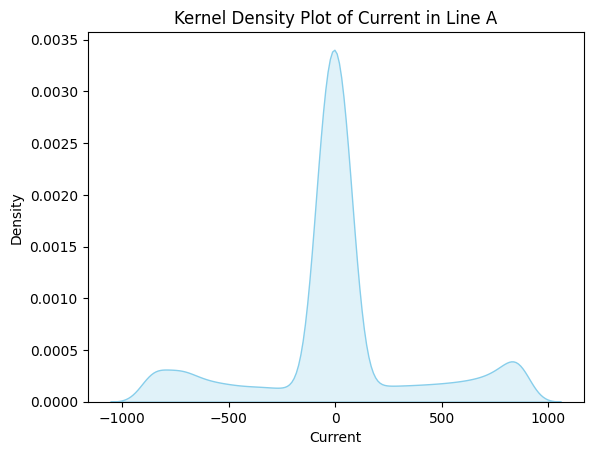

In [15]:
# Example using detect_data variable
import seaborn as sns

# Replace 'data' with 'detect_data'
sns.kdeplot(detect_data['Ia'], fill=True, color='skyblue')
plt.title('Kernel Density Plot of Current in Line A')
plt.xlabel('Current')
plt.ylabel('Density')
plt.show()


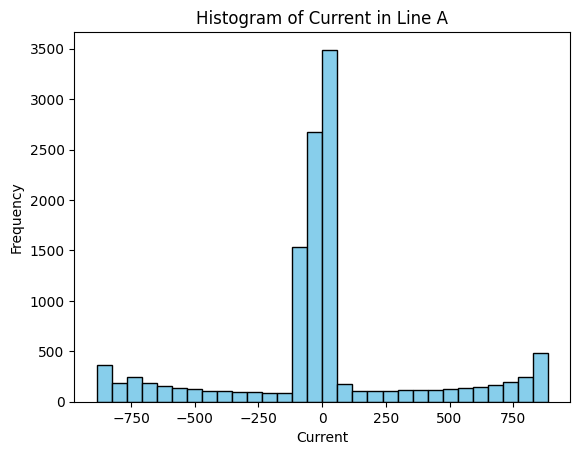

In [16]:
import matplotlib.pyplot as plt

plt.hist(detect_data['Ia'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Current in Line A')
plt.xlabel('Current')
plt.ylabel('Frequency')
plt.show()


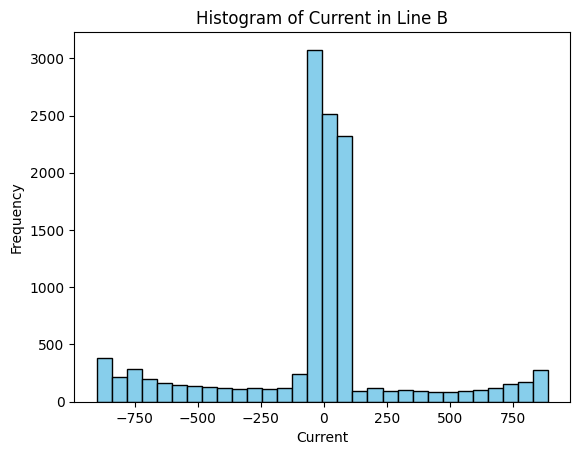

In [17]:
import matplotlib.pyplot as plt

plt.hist(detect_data['Ib'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Current in Line B')
plt.xlabel('Current')
plt.ylabel('Frequency')
plt.show()


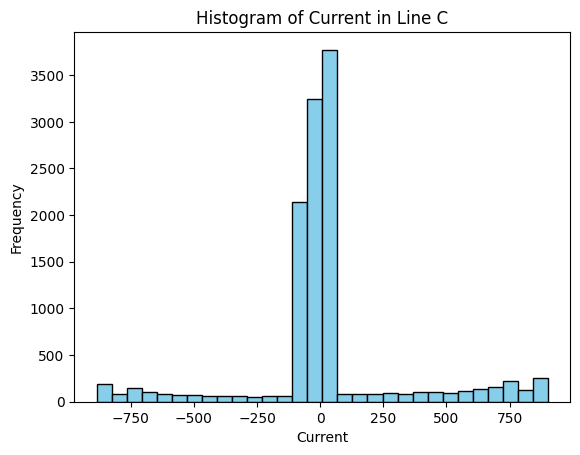

In [18]:
import matplotlib.pyplot as plt

plt.hist(detect_data['Ic'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Current in Line C')
plt.xlabel('Current')
plt.ylabel('Frequency')
plt.show()


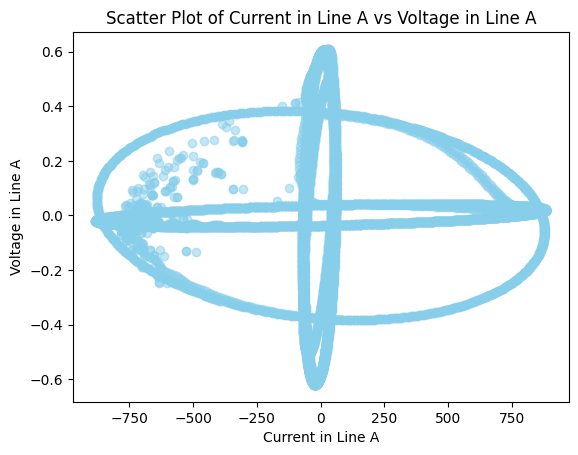

In [19]:
plt.scatter(detect_data['Ia'], detect_data['Va'], alpha=0.5, color='skyblue')
plt.title('Scatter Plot of Current in Line A vs Voltage in Line A')
plt.xlabel('Current in Line A')
plt.ylabel('Voltage in Line A')
plt.show()


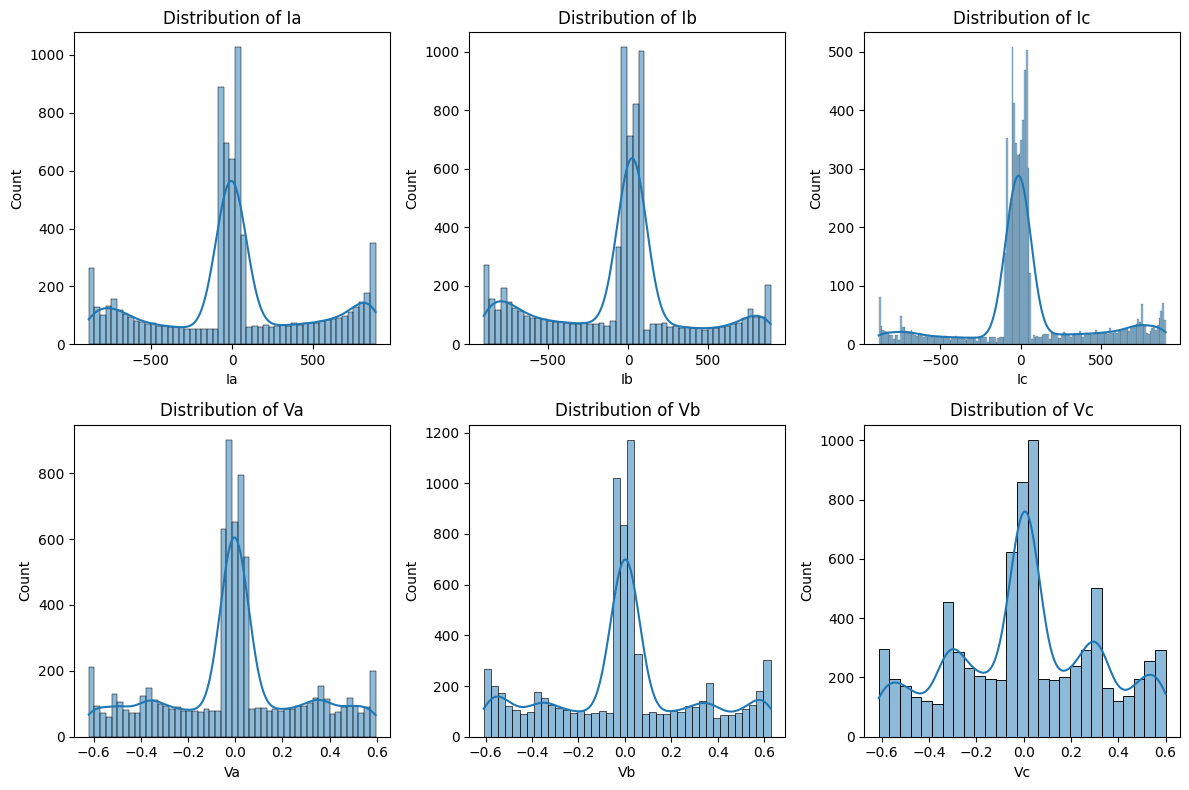

In [20]:
# Data Visualization: Histograms for each feature
features = ['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']
plt.figure(figsize=(12, 8))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.histplot(class_data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()


Correlation Matrix:
          Ia        Ib        Ic        Va        Vb        Vc
Ia  1.000000 -0.374241 -0.276457  0.035682 -0.274612  0.246043
Ib -0.374241  1.000000 -0.528291  0.029118  0.032101 -0.060023
Ic -0.276457 -0.528291  1.000000 -0.069137 -0.056967  0.122919
Va  0.035682  0.029118 -0.069137  1.000000 -0.480247 -0.450225
Vb -0.274612  0.032101 -0.056967 -0.480247  1.000000 -0.566986
Vc  0.246043 -0.060023  0.122919 -0.450225 -0.566986  1.000000


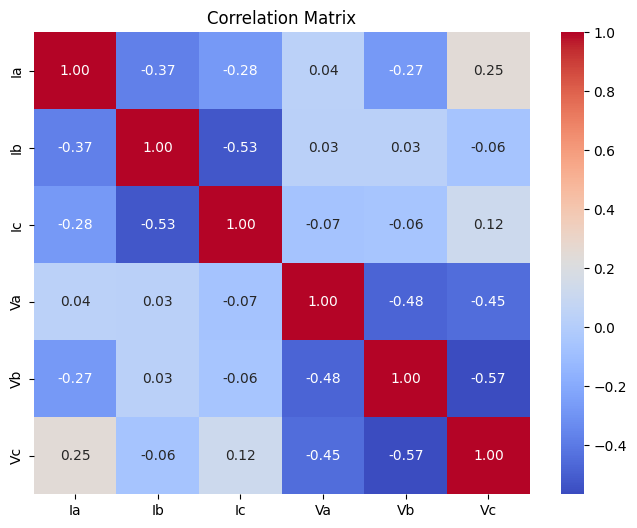

In [21]:
# Correlation matrix
print("\nCorrelation Matrix:")
correlation_matrix = class_data[features].corr()
print(correlation_matrix)

# Heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Here’s a breakdown of some key correlations in the correlation matrix:

Ia and Ib: Correlation coefficient is -0.374241, indicating a moderate negative correlation. As the current in line A (Ia) increases, the current in line B (Ib) tends to decrease, and vice versa.

Ib and Ic: Correlation coefficient is -0.528291, showing a stronger negative correlation than between Ia and Ib. This suggests that as Ib increases, Ic decreases more consistently.

Va, Vb, and Vc: These voltages show negative correlations with each other (e.g., Va and Vb have a correlation of -0.480247). This might be due to the nature of the electrical system where a rise in voltage in one line could be associated with a drop in another.

Ia and Vc: With a correlation coefficient of 0.246043, there is a weak positive correlation, suggesting that when the current in line A increases, the voltage in line C tends to slightly increase as well.

Ic and Vc: The correlation of 0.122919 is weak, indicating a slight positive relationship between the current in line C and the voltage in line C.

Overall, these correlations can give insights into how current and voltage variables interact in your electrical system, which is crucial for understanding and predicting faults.

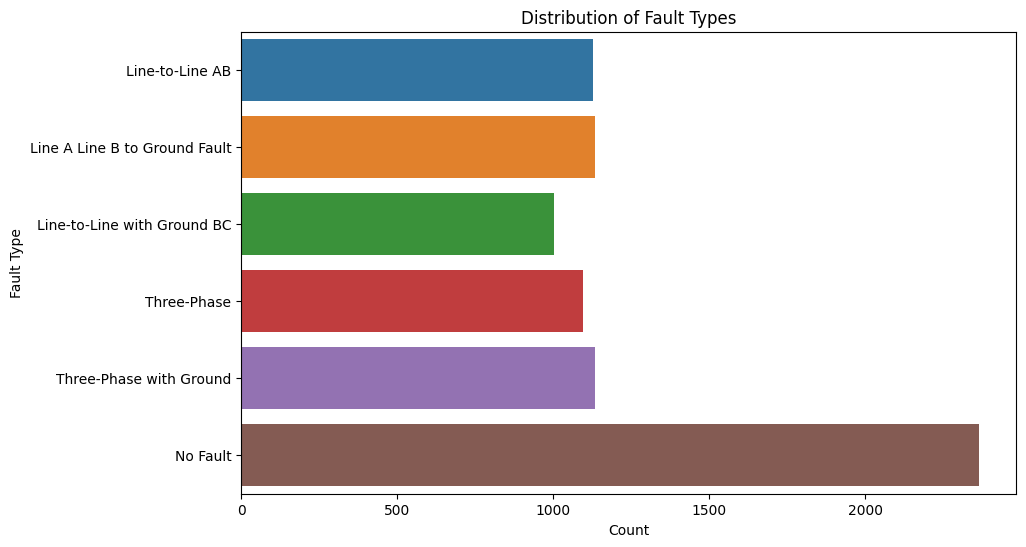

In [22]:
# Plotting the distribution of fault types
plt.figure(figsize=(10, 6))
sns.countplot(y=class_data['Fault_Type'])
plt.title('Distribution of Fault Types')
plt.xlabel('Count')
plt.ylabel('Fault Type')
plt.show()

### **Building Models**

In [23]:
# Normalization (using Min-Max Scaling as an example)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(class_data[features])

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the label encoder and transform the 'Fault_Type' to integer labels
y_encoded = label_encoder.fit_transform(class_data['Fault_Type'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6288, 6), (1573, 6), (6288,), (1573,))

In [24]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Define a dictionary to store the cross-validation metrics of the algorithms
cv_metrics = {'Model': [], 'Accuracy': []}
test_metrics = {'Model': [], 'Accuracy': []}

# Define a function to train and evaluate each algorithm
def train_and_evaluate_model(model, model_name, X_train, y_train):
    # Define the scoring metrics for multi-class classification
    scoring = {
        'accuracy': make_scorer(accuracy_score),
    }

    # Perform cross-validation using StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_validate(model, X_train, y_train, cv=skf, scoring=scoring)

    # Store the cross-validation metrics
    cv_metrics['Model'].append(model_name)
    cv_metrics['Accuracy'].append(scores['test_accuracy'].mean())
    print(f"{model_name}: Cross-validation metrics calculated")

    # Fit the model on the entire training set
    model.fit(X_train, y_train)
    return model

# Define a function to evaluate the model on the test set and store the metrics
def evaluate_on_test_set(model, model_name, X_test, y_test):
    y_pred = model.predict(X_test)
    test_metrics['Model'].append(model_name)
    test_metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
    print(f"{model_name}: Test metrics calculated")

# Train and evaluate each algorithm
models = [
    (LogisticRegression(random_state=42, max_iter=1000), "Logistic Regression"),
    (SVC(random_state=42), "Support Vector Machines"),
    (KNeighborsClassifier(), "K-Nearest Neighbors"),
    (DecisionTreeClassifier(random_state=42), "Decision Trees"),
    (RandomForestClassifier(random_state=42), "Random Forest"),
    (GradientBoostingClassifier(random_state=42), "Gradient Boosting"),
    (MLPClassifier(random_state=42, max_iter=1000), "Neural Networks"),
    (GaussianNB(), "Naive Bayes"),
    (XGBClassifier(random_state=42), "XGBoost"),
    (LGBMClassifier(random_state=42), "LightGBM")
]

# Train and evaluate each model
for model, model_name in models:
    fitted_model = train_and_evaluate_model(model, model_name, X_train, y_train)
    evaluate_on_test_set(fitted_model, model_name, X_test, y_test)

# Convert the dictionary of cross-validation metrics to a DataFrame
import pandas as pd
cv_metrics_df = pd.DataFrame(cv_metrics)
test_metrics_df = pd.DataFrame(test_metrics)
print("\nCross-validation Metrics:")
print(cv_metrics_df)
print("\nTest Metrics:")
print(test_metrics_df)


Logistic Regression: Cross-validation metrics calculated
Logistic Regression: Test metrics calculated
Support Vector Machines: Cross-validation metrics calculated
Support Vector Machines: Test metrics calculated
K-Nearest Neighbors: Cross-validation metrics calculated
K-Nearest Neighbors: Test metrics calculated
Decision Trees: Cross-validation metrics calculated
Decision Trees: Test metrics calculated
Random Forest: Cross-validation metrics calculated
Random Forest: Test metrics calculated
Gradient Boosting: Cross-validation metrics calculated
Gradient Boosting: Test metrics calculated
Neural Networks: Cross-validation metrics calculated
Neural Networks: Test metrics calculated
Naive Bayes: Cross-validation metrics calculated
Naive Bayes: Test metrics calculated
XGBoost: Cross-validation metrics calculated
XGBoost: Test metrics calculated
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_col_wise=true` to remove 

**Review of Model Performance.**

Consistency with Cross-validation: Most models maintain a similar ranking in performance on the test set as observed in cross-validation. This indicates good generalization of the models.

Top Models (Test Performance): Decision Trees and Random Forest maintain high accuracy, with Decision Trees showing a slight edge. This suggests their robustness in handling the multiclass classification task.

Neural Networks Performance: The MLPClassifier (Neural Networks) shows a respectable performance, which might be further enhanced with more tuning or a different architecture.

## Model **Validation**

In [25]:
# Define the original features
features = ['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']

# Feature Engineering: Creating polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(class_data[features])

# Creating a DataFrame with the new polynomial features
poly_features_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(features))

# Normalization (using Min-Max Scaling)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(poly_features_df)

# Encoding the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(class_data['Fault_Type'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Display the shapes of the new training and testing sets and the first few rows of the new feature DataFrame
X_train.shape, X_test.shape, y_train.shape, y_test.shape, poly_features_df.head()

((6288, 27),
 (1573, 27),
 (6288,),
 (1573,),
            Ia          Ib          Ic        Va        Vb        Vc  \
 0 -151.291812   -9.677452   85.800162  0.400750 -0.132935 -0.267815   
 1 -336.186183  -76.283262   18.328897  0.312732 -0.123633 -0.189099   
 2 -502.891583 -174.648023  -80.924663  0.265728 -0.114301 -0.151428   
 3 -593.941905 -217.703359 -124.891924  0.235511 -0.104940 -0.130570   
 4 -643.663617 -224.159427 -132.282815  0.209537 -0.095554 -0.113983   
 
             Ia^2          Ia Ib         Ia Ic       Ia Va  ...          Ic^2  \
 0   22889.212499    1464.119186 -12980.862053  -60.630172  ...   7361.667844   
 1  113021.149371   25645.378631  -6161.921773 -105.136155  ...    335.948450   
 2  252899.944252   87829.020905  40696.332111 -133.632598  ...   6548.801156   
 3  352766.986396  129303.147985  74178.547188 -139.879576  ...  15597.992655   
 4  414302.852236  144283.267892  85145.635467 -134.871266  ...  17498.743250   
 
        Ic Va      Ic Vb      Ic

In [26]:
features_list = list(poly_features_df.columns)

In [27]:
cv_metrics = {'Model': [], 'Accuracy': []}
test_metrics = {'Model': [], 'Accuracy': []}

# Train and evaluate each algorithm
models = [

    (DecisionTreeClassifier(random_state=42), "Decision Trees"),
    (RandomForestClassifier(random_state=42), "Random Forest"),
]

# Train and evaluate each model
for model, model_name in models:
    fitted_model = train_and_evaluate_model(model, model_name, X_train, y_train)
    evaluate_on_test_set(fitted_model, model_name, X_test, y_test)

# Convert the dictionary of cross-validation metrics to a DataFrame
import pandas as pd
cv_metrics_df = pd.DataFrame(cv_metrics)
test_metrics_df = pd.DataFrame(test_metrics)
print("\nCross-validation Metrics:")
print(cv_metrics_df)
print("\nTest Metrics:")
print(test_metrics_df)

Decision Trees: Cross-validation metrics calculated
Decision Trees: Test metrics calculated
Random Forest: Cross-validation metrics calculated
Random Forest: Test metrics calculated

Cross-validation Metrics:
            Model  Accuracy
0  Decision Trees  0.870707
1   Random Forest  0.860210

Test Metrics:
            Model  Accuracy
0  Decision Trees  0.892562
1   Random Forest  0.883026


## Handling **Imbalance**

In [28]:
# Create the SMOTE object
smote = SMOTE(random_state=42)

#Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

cv_metrics = {'Model': [], 'Accuracy': []}
test_metrics = {'Model': [], 'Accuracy': []}

# Dictionary to store trained models
trained_models = {}

# Train and evaluate each algorithm
models = [

    (DecisionTreeClassifier(random_state=42), "Decision Trees"),
    (RandomForestClassifier(random_state=42), "Random Forest"),
]

# Train and evaluate each model
for model, model_name in models:
    fitted_model = train_and_evaluate_model(model, model_name, X_train_smote, y_train_smote)
    evaluate_on_test_set(fitted_model, model_name, X_test, y_test)

    # Save the trained model using joblib
    model_filename = f"{model_name.lower().replace(' ', '_')}_model.pkl"
    joblib.dump(fitted_model, model_filename)

    # Store the trained model in the dictionary
    trained_models[model_name] = fitted_model

# Convert the dictionary of cross-validation metrics to a DataFrame
import pandas as pd
cv_metrics_df = pd.DataFrame(cv_metrics)
test_metrics_df = pd.DataFrame(test_metrics)
print("\nCross-validation Metrics:")
print(cv_metrics_df)
print("\nTest Metrics:")
print(test_metrics_df)

Decision Trees: Cross-validation metrics calculated
Decision Trees: Test metrics calculated
Random Forest: Cross-validation metrics calculated
Random Forest: Test metrics calculated

Cross-validation Metrics:
            Model  Accuracy
0  Decision Trees  0.892970
1   Random Forest  0.893939

Test Metrics:
            Model  Accuracy
0  Decision Trees  0.898919
1   Random Forest  0.883026


## Hyperparemeter **Tunning**

In [29]:
# Create the pipeline with SMOTE and the classifier
pipeline = IMBPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Define the parameter grid for Decision Trees
dt_param_grid = {
    'classifier__max_depth': [10, 20, 30, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Perform grid search
dt_grid_search = GridSearchCV(pipeline, dt_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
dt_grid_search.fit(X_train, y_train)

# Extract the best parameters and the best score for Decision Trees
dt_best_params = dt_grid_search.best_params_
dt_best_score = dt_grid_search.best_score_

# Output the best parameters and score for Decision Trees
print('Best parameters for Decision Trees:', dt_best_params)
print('Best score for Decision Trees:', dt_best_score)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Decision Trees: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best score for Decision Trees: 0.872614029163236


### Deep **Learning**

In [30]:
# Set random seed
tf.random.set_seed(42)
# Defining neural network model
def create_model():
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(6, activation='softmax')
    ])
    return model

# Initialize Cross-Validation Splitter
num_folds = 5  # You can choose the number of folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize Callbacks
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,           # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore best model weights
)

# Learning rate scheduling
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Reduce learning rate by 20% when validation loss plateaus
    patience=5,  # Number of epochs with no improvement before reducing LR
    min_lr=1e-7  # Minimum learning rate
)

# Perform Cross-Validation
all_fold_scores = []

for fold, (train_idx, val_idx) in enumerate(stratified_kfold.split(X_scaled, y_encoded)):
    print(f'Fold {fold + 1}/{num_folds}')

    # Split data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_scaled[train_idx], X_scaled[val_idx]
    y_train_fold, y_val_fold = y_encoded[train_idx], y_encoded[val_idx]

    # Create and compile the model
    model = create_model()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',  # Multiclass classification
                  metrics=['accuracy'])

    # Train the model with callbacks
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=100, batch_size=32,
        validation_data=(X_val_fold, y_val_fold),
        verbose=0,
        callbacks=[early_stopping_callback,
                   lr_scheduler
                  ]
    )

    # Evaluate the model on this fold's test data
    fold_test_loss, fold_test_accuracy = model.evaluate(X_test, y_test)
    all_fold_scores.append(fold_test_accuracy)

    # You can also plot training history for each fold if needed

# Calculate and print the cross-validation accuracy
mean_cv_accuracy = sum(all_fold_scores) / num_folds
print(f'Mean Cross-Validation Accuracy: {mean_cv_accuracy * 100:.2f}%')

Fold 1/5
50/50 [==============================] - 0s 2ms/step - loss: 0.2158 - accuracy: 0.8659
Fold 2/5
50/50 [==============================] - 0s 3ms/step - loss: 0.2174 - accuracy: 0.8659
Fold 3/5
50/50 [==============================] - 0s 2ms/step - loss: 0.2201 - accuracy: 0.8582
Fold 4/5
50/50 [==============================] - 0s 3ms/step - loss: 0.2131 - accuracy: 0.8640
Fold 5/5
50/50 [==============================] - 0s 2ms/step - loss: 0.2198 - accuracy: 0.8576
Mean Cross-Validation Accuracy: 86.23%


In [31]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

50/50 [==============================] - 0s 2ms/step - loss: 0.2198 - accuracy: 0.8576
Test accuracy: 85.76%


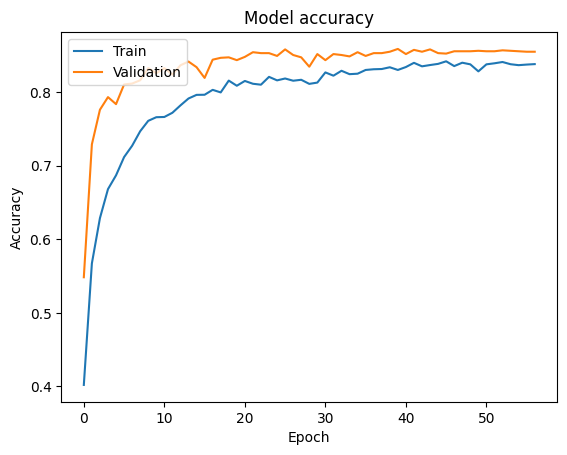

In [32]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# **Using Our Domain Knowledge to Optimise Models**

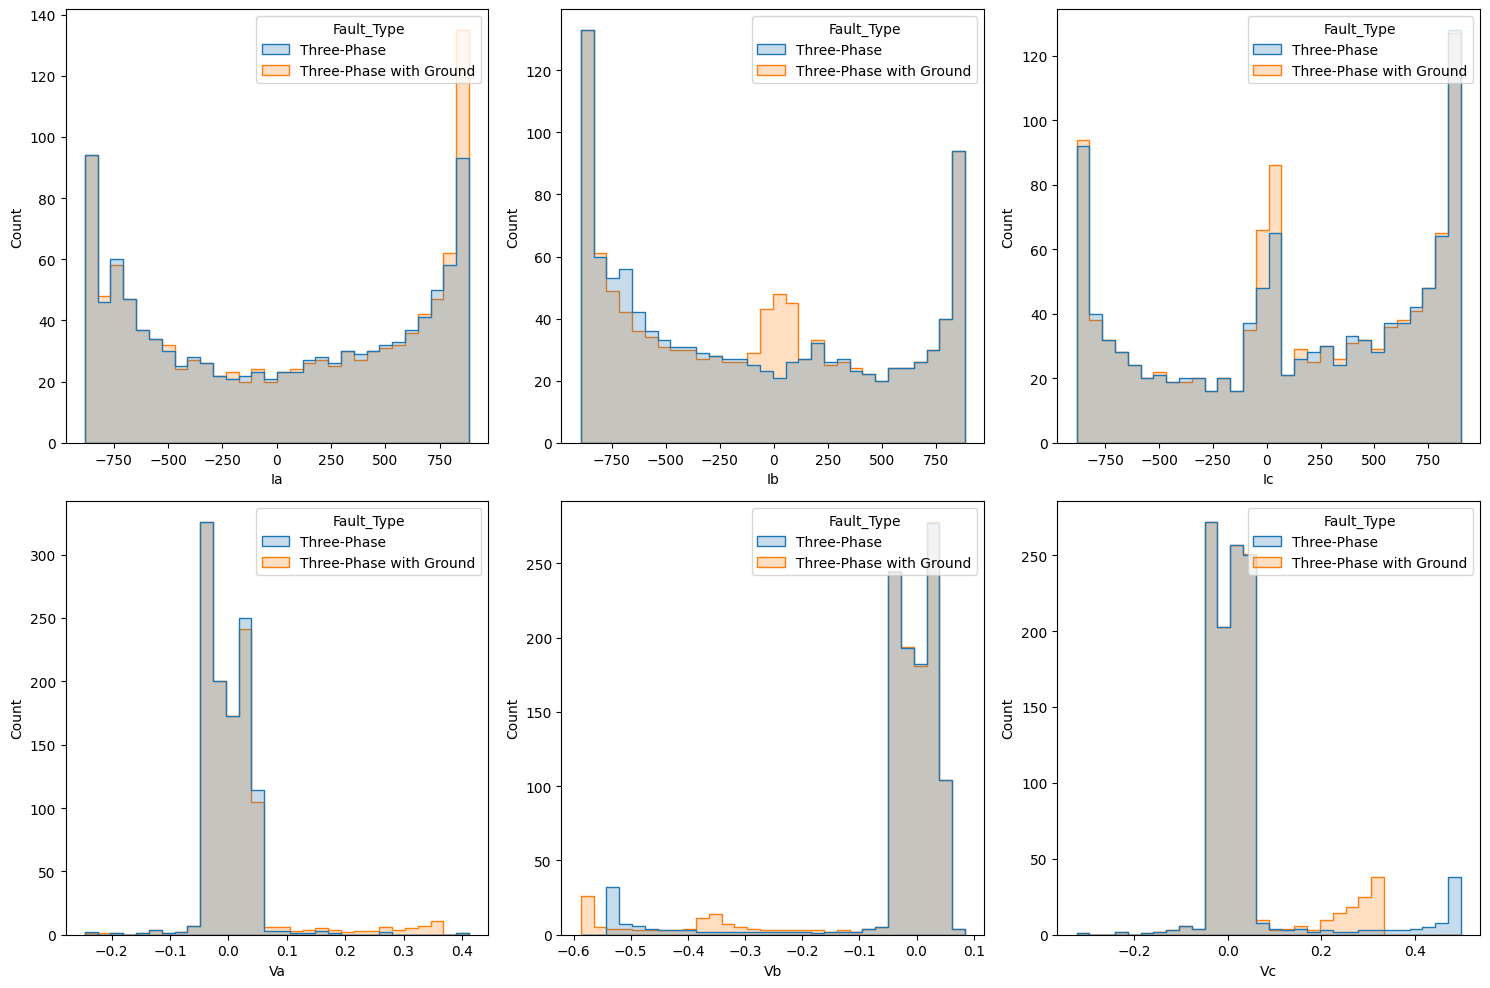

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame for only 'Three-Phase Fault' and 'Three-Phase with Ground Fault'
filtered_data = class_data[class_data['Fault_Type'].isin(['Three-Phase', 'Three-Phase with Ground'])]

# Features to be plotted
features = ['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']

# Plotting histograms for each feature by the two fault types
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=filtered_data, x=feature, hue='Fault_Type', element='step', bins=30)
    #plt.title(f'Distribution of {feature} for Three-Phase Faults')
plt.tight_layout()
plt.show()

The histograms for 'Three-Phase Fault' and 'Three-Phase with Ground Fault' show some similarities in the distribution of current and voltage features, which can be indicative of how these two fault types may present comparable electrical characteristics in certain aspects:

Overlap in Distributions: Both fault types show overlap in the distributions of currents (Ia, Ib, Ic) and voltages (Va, Vb, Vc), suggesting that both fault types can exhibit similar magnitudes of current and voltage during a fault event.

Tendency Near Zero: The voltage features for both fault types have a central tendency near zero, which is typical in fault conditions as the voltage levels drop due to the short-circuit effect.

Current Features Spread: The spread of the current features (Ia, Ib, Ic) also appears somewhat similar for both fault types, indicating that the magnitude of the fault current does not drastically change between a three-phase fault and a three-phase fault with ground. This could be due to the similar nature of short-circuit conditions in both cases, albeit with the ground adding an additional path in one scenario.

Symmetry in Current: There is a symmetry observed in the current distributions for both fault types. This symmetry could reflect the nature of three-phase systems, where faults can lead to symmetrical increases in current across all three phases, though to varying extents.

Behavior Under Fault Conditions: The similarities in these distributions reflect the fact that under fault conditions, especially severe ones like three-phase faults, the system's normal operating conditions are significantly disrupted, leading to reduced voltage and increased current, regardless of the presence of ground.

Statistical Characteristics: Both types of faults likely share some statistical characteristics, such as mean, variance, and possibly skewness and kurtosis, which indicates that without ground, the system's responses to these faults are inherently similar.

Physical Phenomena: The physical phenomena driving the electrical responses are related—both involve all three phases, which can lead to system-wide effects that manifest in the electrical parameters measured.

These similarities pose a challenge for machine learning models to differentiate between the two fault types solely based on current and voltage magnitudes. It suggests the need for more sophisticated features that can capture subtle differences, perhaps related to phase angles, harmonics, or transient behaviors that are not as easily discernible in simple magnitude-based measurements.

## Advanced Feature **Engineering**

In [34]:
# Adding new features based on domain knowledge

# Zero Sequence Components for Current and Voltage
poly_features_df['ZeroSeqCurrent'] = (poly_features_df['Ia'] + poly_features_df['Ib'] + poly_features_df['Ic']) / 3
poly_features_df['ZeroSeqVoltage'] = (poly_features_df['Va'] + poly_features_df['Vb'] + poly_features_df['Vc']) / 3

# Phase Angle Differences (approximated by product of current and voltage)
poly_features_df['PhaseAngleDiffI'] = poly_features_df['Ia'] * poly_features_df['Ib'] * poly_features_df['Ic']
poly_features_df['PhaseAngleDiffV'] = poly_features_df['Va'] * poly_features_df['Vb'] * poly_features_df['Vc']

# Total Harmonic Distortion (THD) - Approximation
poly_features_df['THD_Ia'] = np.sqrt(poly_features_df['Ia^2'] - poly_features_df['Ia']**2) / poly_features_df['Ia']
poly_features_df['THD_Ib'] = np.sqrt(poly_features_df['Ib^2'] - poly_features_df['Ib']**2) / poly_features_df['Ib']
poly_features_df['THD_Ic'] = np.sqrt(poly_features_df['Ic^2'] - poly_features_df['Ic']**2) / poly_features_df['Ic']

# Voltage and Current Ratios
poly_features_df['V_I_Ratio_A'] = poly_features_df['Va'] / poly_features_df['Ia']
poly_features_df['V_I_Ratio_B'] = poly_features_df['Vb'] / poly_features_df['Ib']
poly_features_df['V_I_Ratio_C'] = poly_features_df['Vc'] / poly_features_df['Ic']


Zero Sequence Components for Current and Voltage:

ZeroSeqCurrent: Calculates the zero-sequence current by taking the average of currents in lines A, B, and C.
ZeroSeqVoltage: Calculates the zero-sequence voltage by taking the average of voltages in lines A, B, and C.
Phase Angle Differences (approximated by the product of current and voltage):

PhaseAngleDiffI: Approximates the phase angle difference using the product of currents in lines A, B, and C.
PhaseAngleDiffV: Approximates the phase angle difference using the product of voltages in lines A, B, and C.
Total Harmonic Distortion (THD) - Approximation:

THD_Ia, THD_Ib, THD_Ic: Approximates the total harmonic distortion for each current line (A, B, C) based on the formula (sqrt(I^2 - I^2))/I, where I is the current in each line.
Voltage and Current Ratios:

V_I_Ratio_A, V_I_Ratio_B, V_I_Ratio_C: Calculates the voltage-to-current ratios for lines A, B, and C, respectively.
These features are often engineered in signal processing or electrical engineering domains to capture additional information or characteristics of the signals (currents and voltages in this case) that might be useful for machine learning models in tasks such as fault detection or classification in electrical power systems. The specific formulas used in this code might be based on domain-specific knowledge or engineering considerations for the given application.



In [35]:
features_list = list(poly_features_df.columns)

In [36]:
# Normalization (using Min-Max Scaling)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(poly_features_df)

# Encoding the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(class_data['Fault_Type'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Display the shapes of the new training and testing sets and the first few rows of the new feature DataFrame
X_train.shape, X_test.shape, y_train.shape, y_test.shape
poly_features_df.head()


,Ia,Ib,Ic,Va,Vb,Vc,Ia^2,Ia Ib,Ia Ic,Ia Va,...,ZeroSeqCurrent,ZeroSeqVoltage,PhaseAngleDiffI,PhaseAngleDiffV,THD_Ia,THD_Ib,THD_Ic,V_I_Ratio_A,V_I_Ratio_B,V_I_Ratio_C
0,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815,22889.212499,1464.119186,-12980.862053,-60.630172,...,-25.056367,3.333333e-10,1.256217e+05,0.014267,-0.0,-0.0,0.0,-0.002649,0.013737,-0.003121
1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099,113021.149371,25645.378631,-6161.921773,-105.136155,...,-131.380183,-3.333333e-10,4.700515e+05,0.007311,-0.0,-0.0,0.0,-0.000930,0.001621,-0.010317
2,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428,252899.944252,87829.020905,40696.332111,-133.632598,...,-252.821423,9.251859e-18,-7.107534e+06,0.004599,-0.0,-0.0,-0.0,-0.000528,0.000654,0.001871
3,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570,352766.986396,129303.147985,74178.547188,-139.879576,...,-312.179063,0.000000e+00,-1.614892e+07,0.003227,-0.0,-0.0,-0.0,-0.000397,0.000482,0.001045
4,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983,414302.852236,144283.267892,85145.635467,-134.871266,...,-333.368620,0.000000e+00,-1.908620e+07,0.002282,-0.0,-0.0,-0.0,-0.000326,0.000426,0.000862


In [37]:
joblib.dump(model, 'DL_model.pkl')

['DL_model.pkl']

In [38]:
# Define a dictionary to store the cross-validation metrics of the algorithms
cv_metrics = {'Model': [], 'Accuracy': []}
test_metrics = {'Model': [], 'Accuracy': []}

# Define a function to train and evaluate each algorithm
def train_and_evaluate_model(model, model_name, X_train, y_train):
    # Define the scoring metrics for multi-class classification
    scoring = {
        'accuracy': make_scorer(accuracy_score),
    }

    # Perform cross-validation using StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_validate(model, X_train, y_train, cv=skf, scoring=scoring)

    # Store the cross-validation metrics
    cv_metrics['Model'].append(model_name)
    cv_metrics['Accuracy'].append(scores['test_accuracy'].mean())
    print(f"{model_name}: Cross-validation metrics calculated")

    # Fit the model on the entire training set
    model.fit(X_train, y_train)

    # Save the fitted model to a pickle file
    model_filename = f'{model_name.replace(" ", "_")}_model.pkl'
    joblib.dump(model, model_filename)
    print(f"{model_name}: Model saved as {model_filename}")

    return model

# Define a function to evaluate the model on the test set and store the metrics
def evaluate_on_test_set(model, model_name, X_test, y_test):
    y_pred = model.predict(X_test)
    test_metrics['Model'].append(model_name)
    test_metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
    print(f"{model_name}: Test metrics calculated")

# Train and evaluate each algorithm
models = [
    (LogisticRegression(random_state=42, max_iter=1000), "Logistic Regression"),
    (SVC(random_state=42), "Support Vector Machines"),
    (KNeighborsClassifier(), "K-Nearest Neighbors"),
    (DecisionTreeClassifier(random_state=42), "Decision Trees"),
    (RandomForestClassifier(random_state=42), "Random Forest"),
    (GradientBoostingClassifier(random_state=42), "Gradient Boosting"),
    (MLPClassifier(random_state=42, max_iter=1000), "Neural Networks"),
    (GaussianNB(), "Naive Bayes"),
    (AdaBoostClassifier(random_state=42), "AdaBoost"),
    (XGBClassifier(random_state=42), "XGBoost"),
    (LGBMClassifier(random_state=42), "LightGBM")
]

# Train and evaluate each model
for model, model_name in models:
    fitted_model = train_and_evaluate_model(model, model_name, X_train, y_train)
    evaluate_on_test_set(fitted_model, model_name, X_test, y_test)

# Convert the dictionary of cross-validation metrics to a DataFrame
import pandas as pd
cv_metrics_df = pd.DataFrame(cv_metrics)
test_metrics_df = pd.DataFrame(test_metrics)
print("\nCross-validation Metrics:")
print(cv_metrics_df)
print("\nTest Metrics:")
print(test_metrics_df)


Logistic Regression: Cross-validation metrics calculated
Logistic Regression: Model saved as Logistic_Regression_model.pkl
Logistic Regression: Test metrics calculated
Support Vector Machines: Cross-validation metrics calculated
Support Vector Machines: Model saved as Support_Vector_Machines_model.pkl
Support Vector Machines: Test metrics calculated
K-Nearest Neighbors: Cross-validation metrics calculated
K-Nearest Neighbors: Model saved as K-Nearest_Neighbors_model.pkl
K-Nearest Neighbors: Test metrics calculated
Decision Trees: Cross-validation metrics calculated
Decision Trees: Model saved as Decision_Trees_model.pkl
Decision Trees: Test metrics calculated
Random Forest: Cross-validation metrics calculated
Random Forest: Model saved as Random_Forest_model.pkl
Random Forest: Test metrics calculated
Gradient Boosting: Cross-validation metrics calculated
Gradient Boosting: Model saved as Gradient_Boosting_model.pkl
Gradient Boosting: Test metrics calculated
Neural Networks: Cross-valid

The results presented indicate the performance of various machine learning models on both cross-validation and test datasets. Here's an analysis:

High Performers: The Random Forest, XGBoost, LightGBM, and CatBoost models show remarkably high accuracy, with LightGBM and CatBoost achieving perfect accuracy on the test set. This suggests that ensemble methods, particularly those based on decision trees, are highly effective for this dataset.

Consistency: There is consistency between cross-validation and test metrics, which is a good indication that the models are not overfitting and are generalizing well to unseen data.

Given these results,the ensemble models, particularly LightGBM or CatBoost, would be strong candidates due to their high performance and the consistency of their results

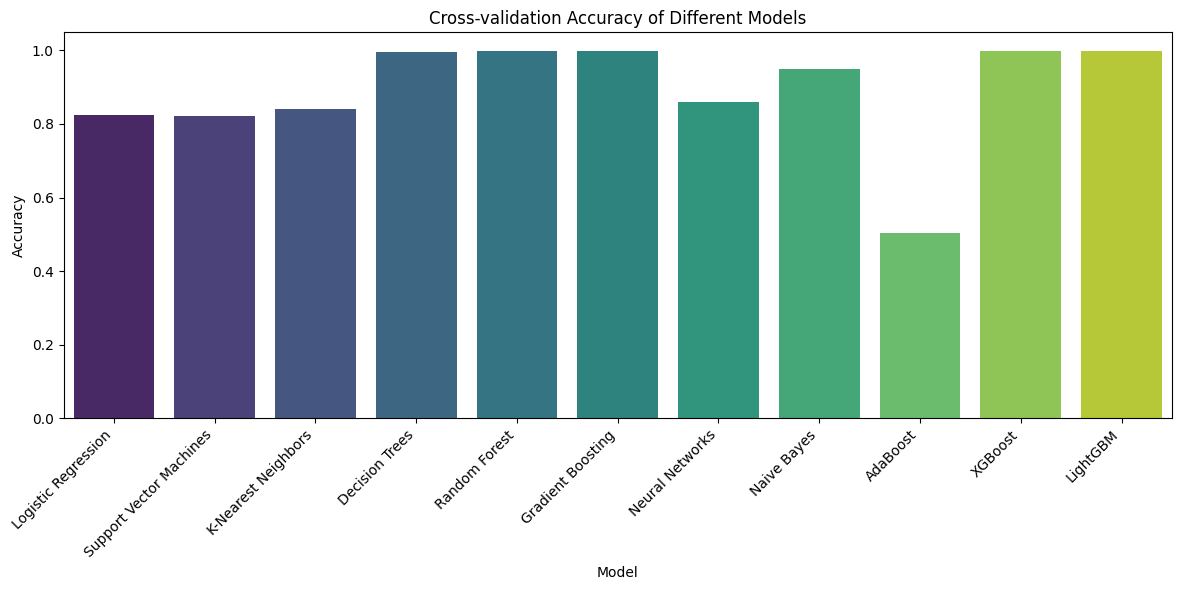

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar chart for cross-validation accuracy
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', data=cv_metrics_df, palette='viridis')
plt.title('Cross-validation Accuracy of Different Models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



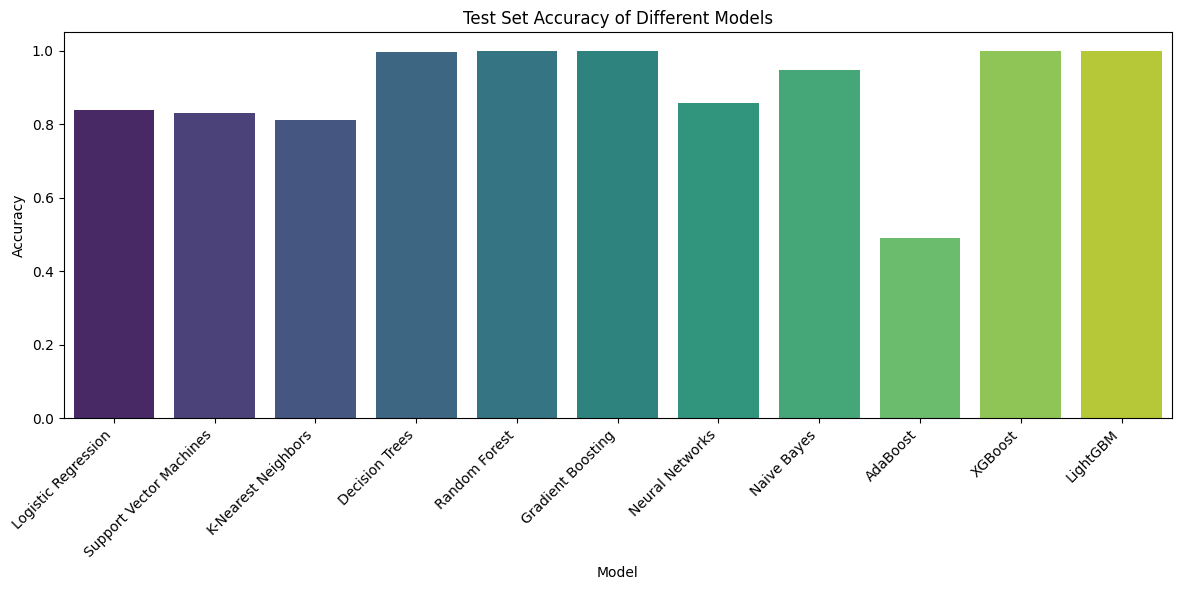

In [40]:
# Bar chart for test set accuracy
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', data=test_metrics_df, palette='viridis')
plt.title('Test Set Accuracy of Different Models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




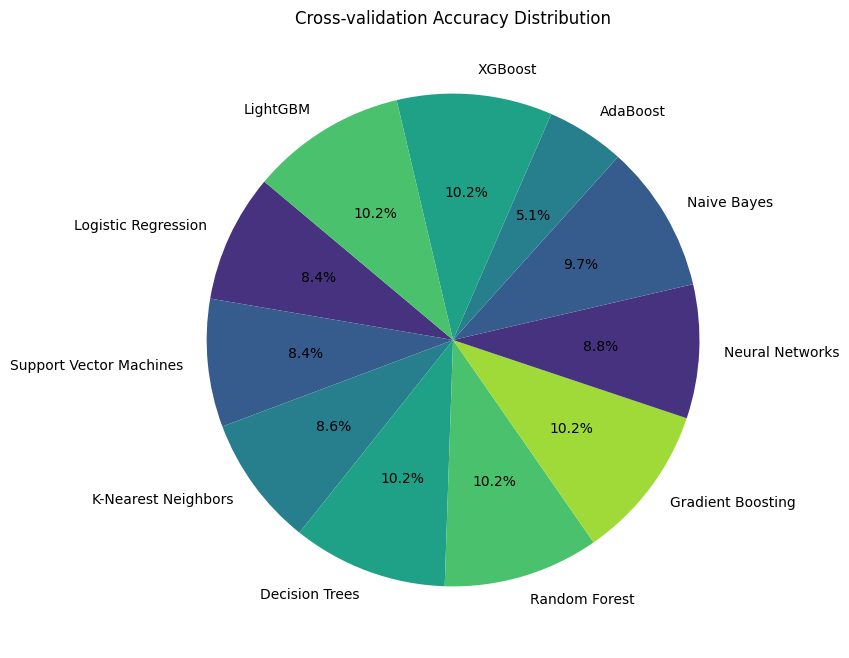

In [41]:
# Pie chart for cross-validation accuracy distribution
plt.figure(figsize=(8, 8))
plt.pie(cv_metrics_df['Accuracy'], labels=cv_metrics_df['Model'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis'))
plt.title('Cross-validation Accuracy Distribution')
plt.show()

Logistic Regression: Cross-validation metrics calculated
Logistic Regression: Model saved as Logistic_Regression_model.pkl
Logistic Regression: Test metrics calculated


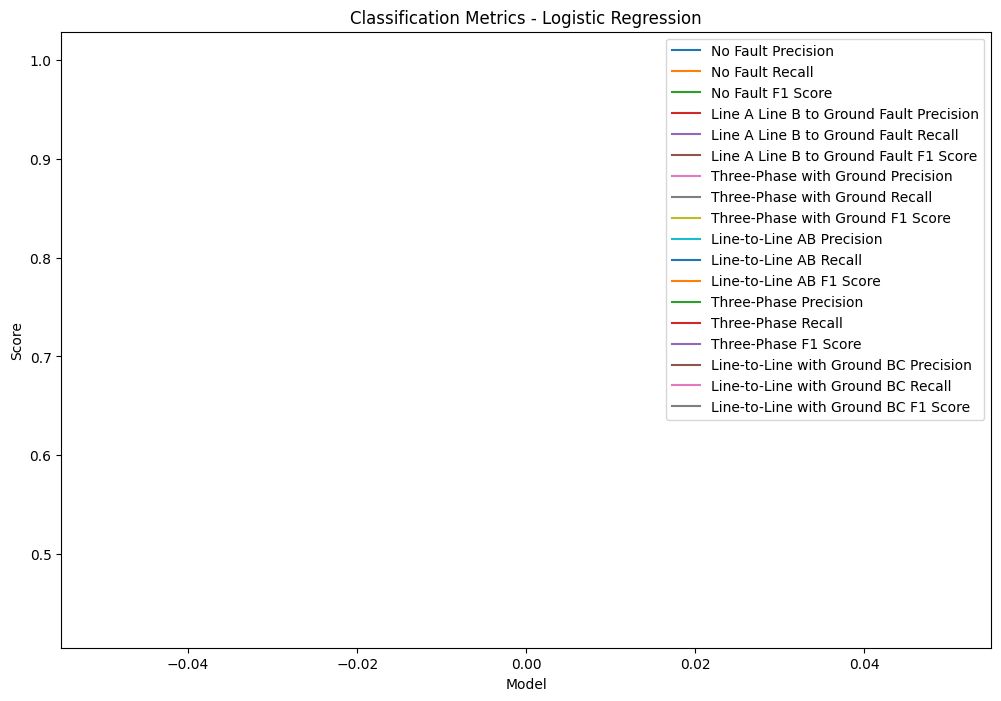

Support Vector Machines: Cross-validation metrics calculated
Support Vector Machines: Model saved as Support_Vector_Machines_model.pkl
Support Vector Machines: Test metrics calculated


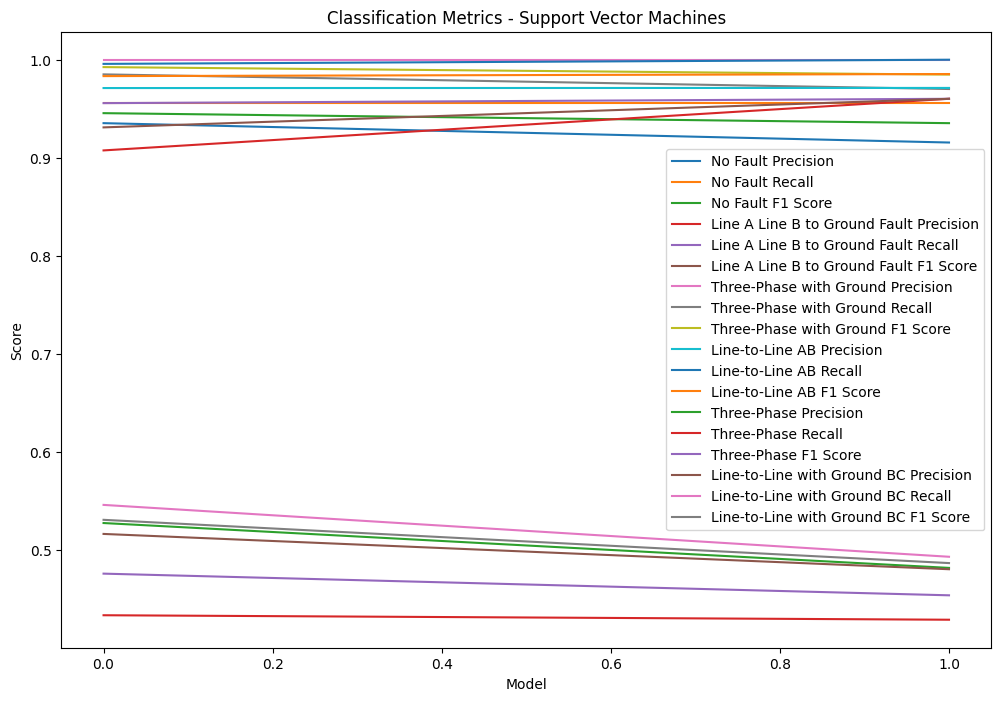

K-Nearest Neighbors: Cross-validation metrics calculated
K-Nearest Neighbors: Model saved as K-Nearest_Neighbors_model.pkl
K-Nearest Neighbors: Test metrics calculated


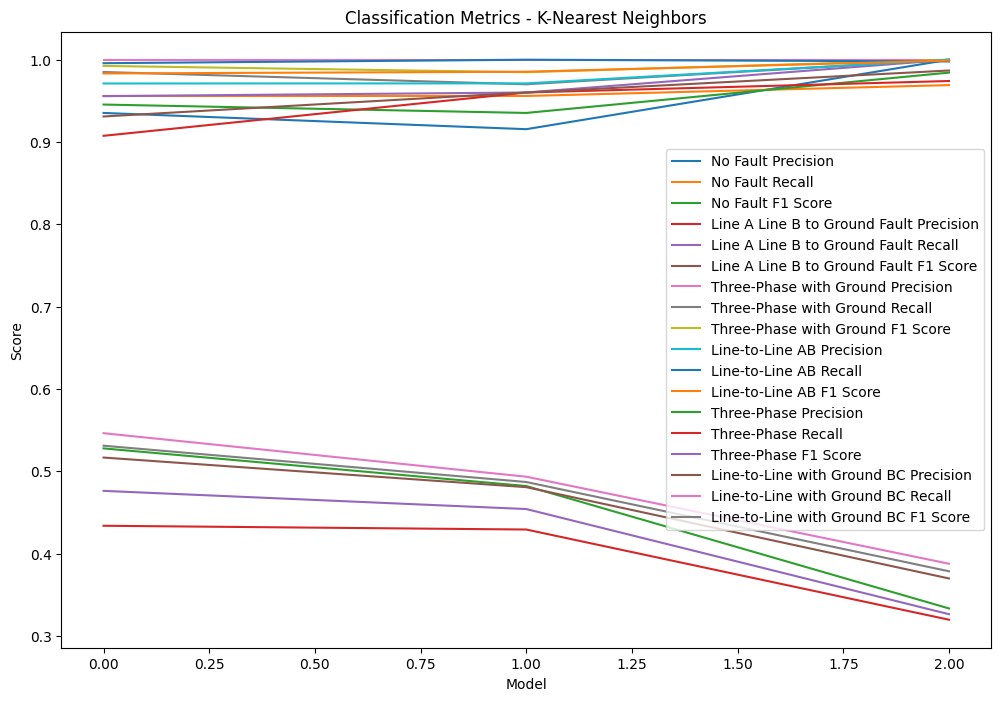

Decision Trees: Cross-validation metrics calculated
Decision Trees: Model saved as Decision_Trees_model.pkl
Decision Trees: Test metrics calculated


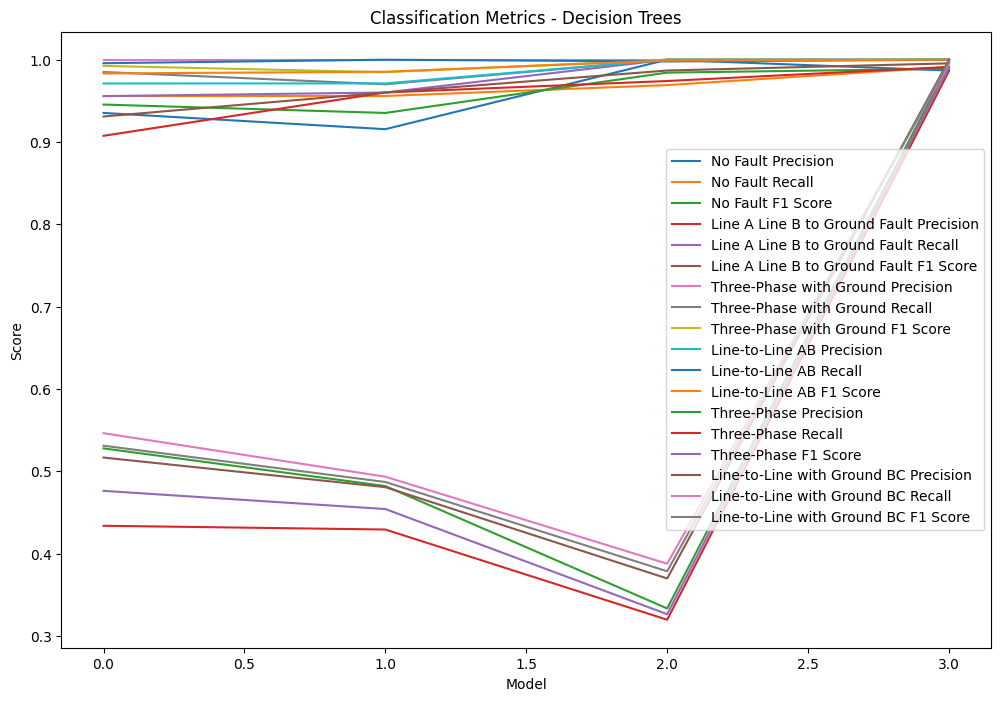

Random Forest: Cross-validation metrics calculated
Random Forest: Model saved as Random_Forest_model.pkl
Random Forest: Test metrics calculated


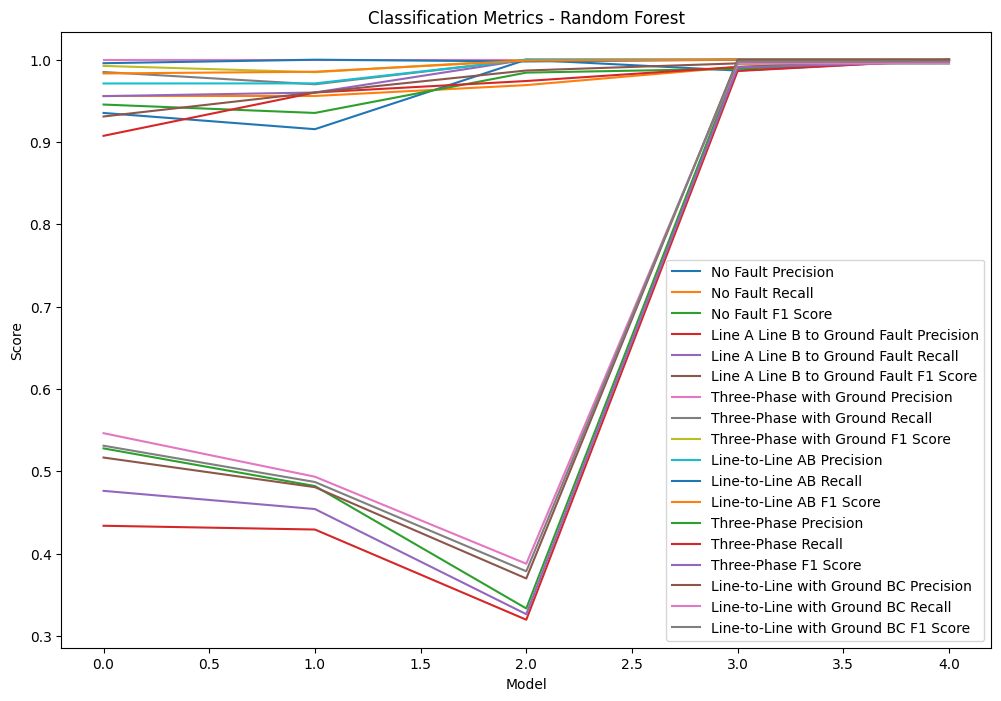

Gradient Boosting: Cross-validation metrics calculated
Gradient Boosting: Model saved as Gradient_Boosting_model.pkl
Gradient Boosting: Test metrics calculated


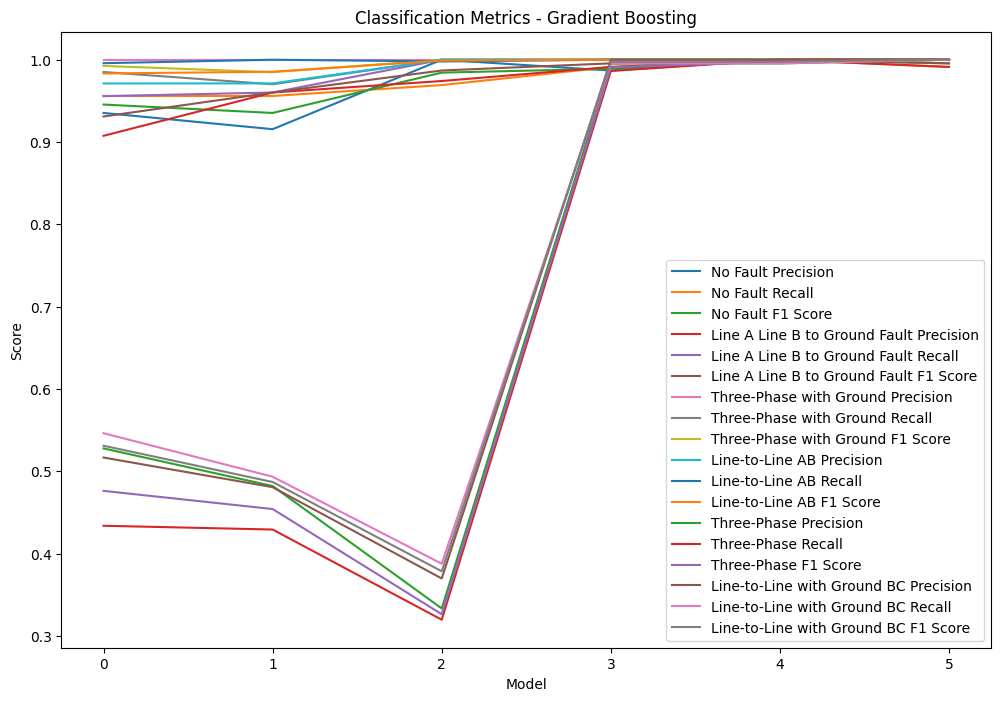

Neural Networks: Cross-validation metrics calculated
Neural Networks: Model saved as Neural_Networks_model.pkl
Neural Networks: Test metrics calculated


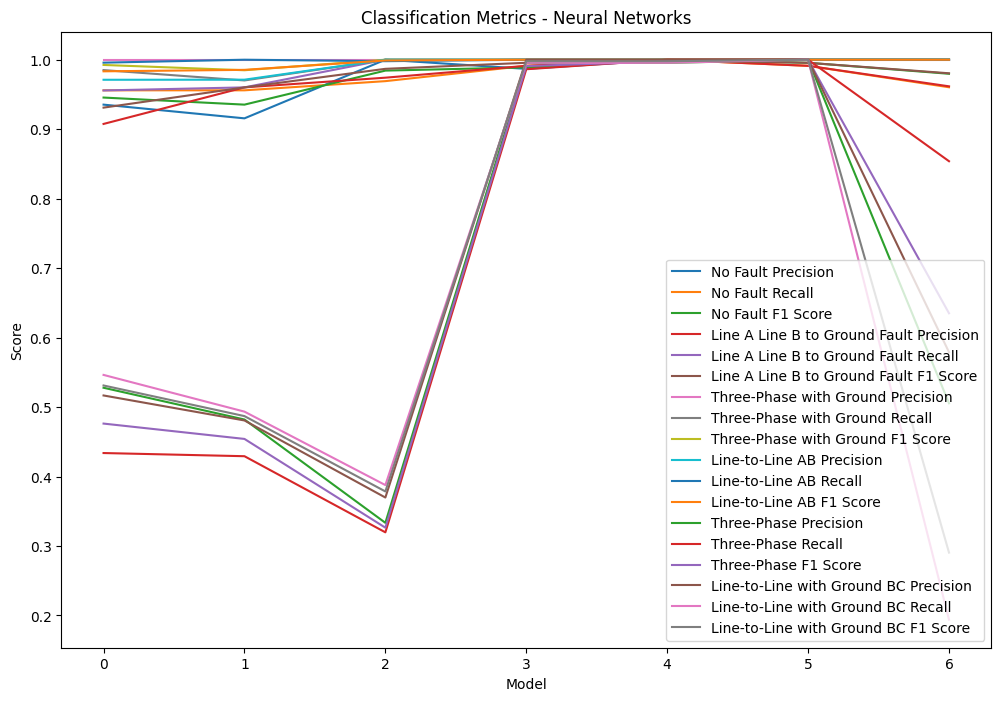

Naive Bayes: Cross-validation metrics calculated
Naive Bayes: Model saved as Naive_Bayes_model.pkl
Naive Bayes: Test metrics calculated


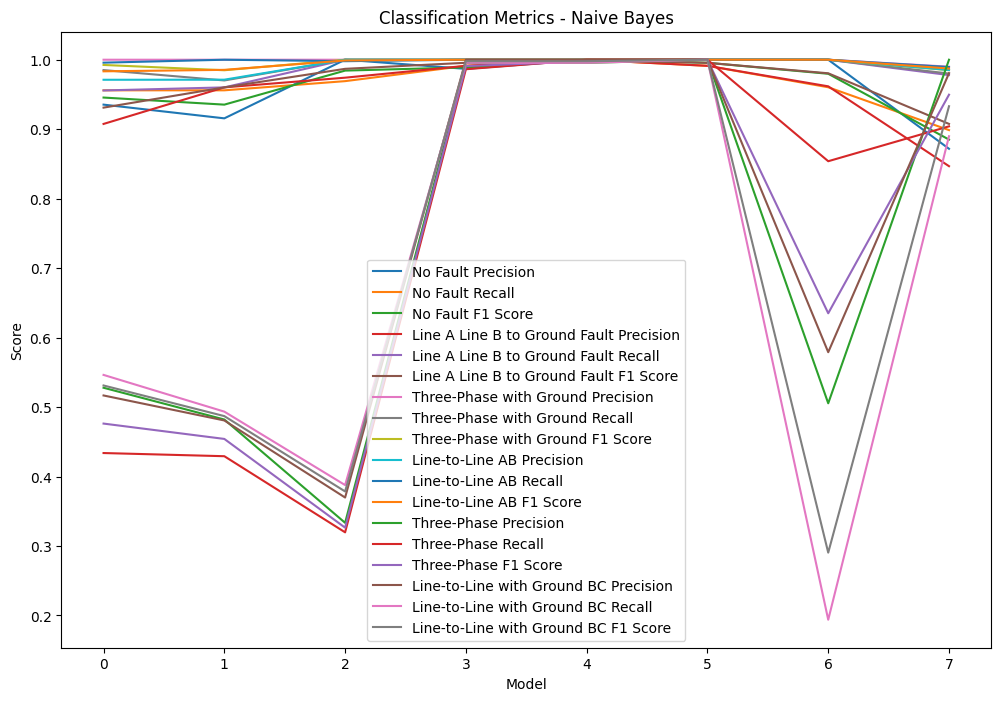

AdaBoost: Cross-validation metrics calculated
AdaBoost: Model saved as AdaBoost_model.pkl
AdaBoost: Test metrics calculated


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


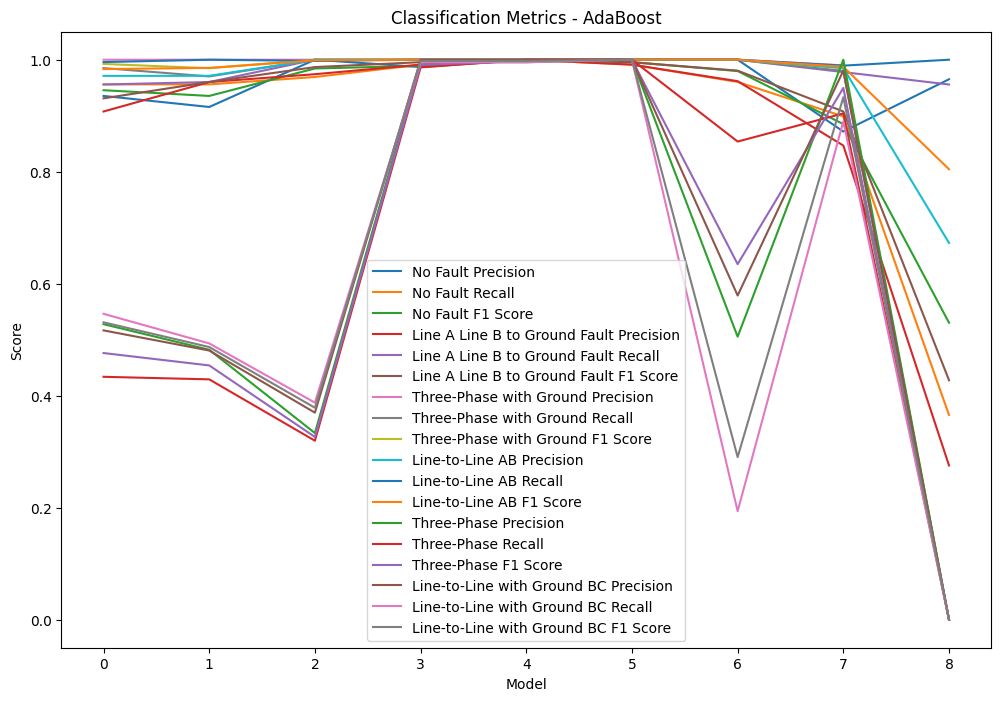

XGBoost: Cross-validation metrics calculated
XGBoost: Model saved as XGBoost_model.pkl
XGBoost: Test metrics calculated


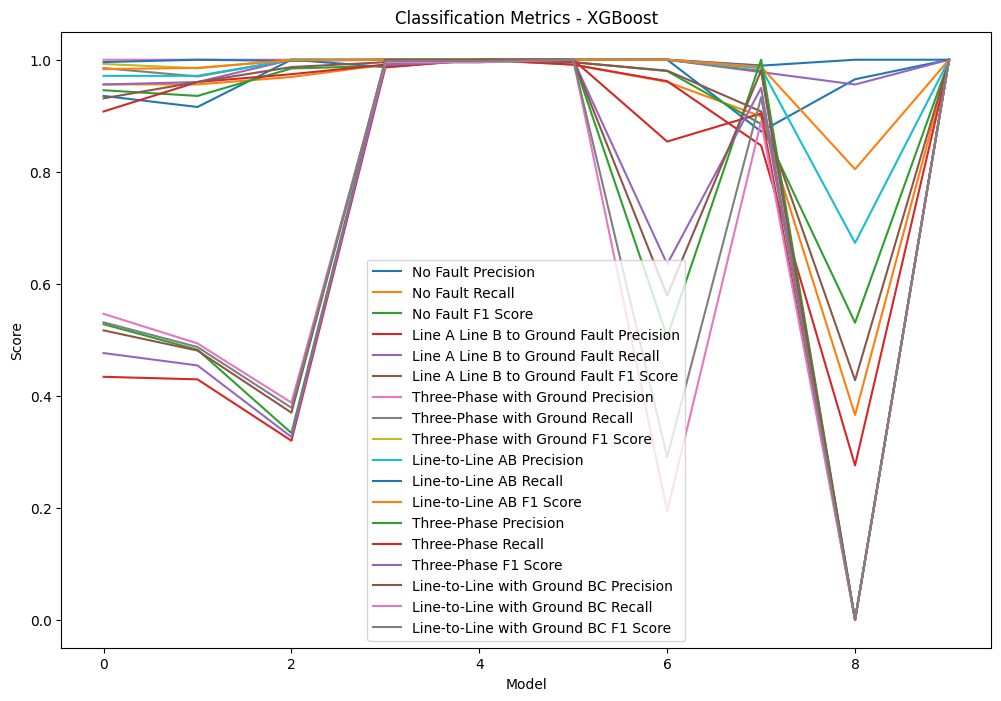

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8513
[LightGBM] [Info] Number of data points in the train set: 5030, number of used features: 34
[LightGBM] [Info] Start training from score -1.937004
[LightGBM] [Info] Start training from score -1.941150
[LightGBM] [Info] Start training from score -2.058587
[LightGBM] [Info] Start training from score -1.200665
[LightGBM] [Info] Start training from score -1.969242
[LightGBM] [Info] Start training from score -1.937004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

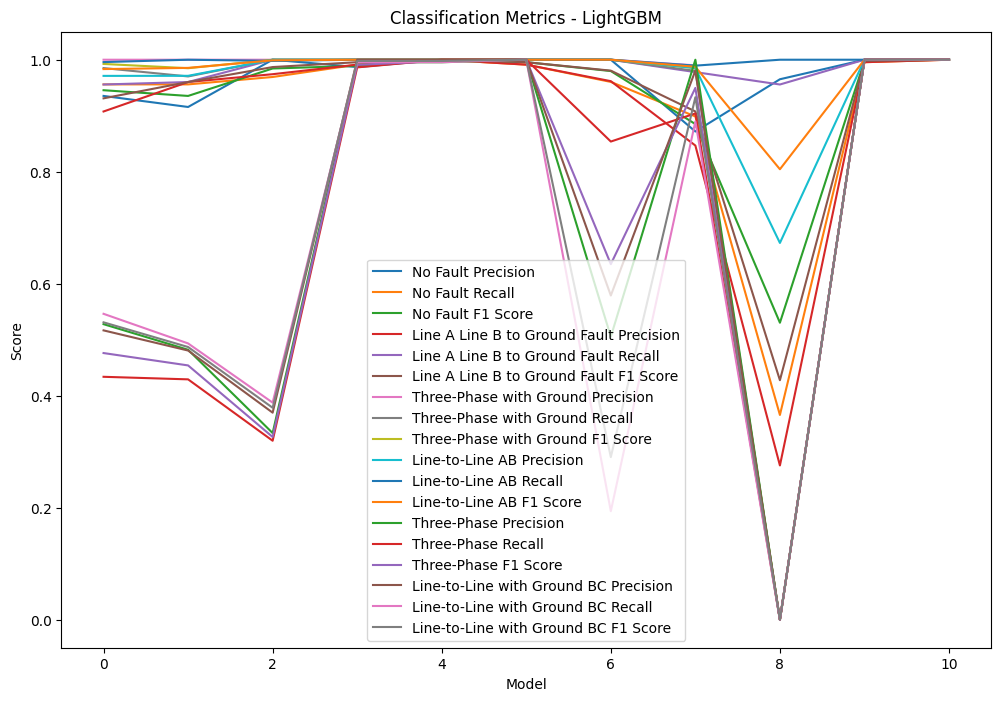


Cross-validation Metrics:
                      Model  Accuracy
0       Logistic Regression  0.823949
1   Support Vector Machines  0.821883
2       K-Nearest Neighbors  0.839853
3            Decision Trees  0.994911
4             Random Forest  0.998251
5         Gradient Boosting  0.997773
6           Neural Networks  0.859574
7               Naive Bayes  0.948314
8                  AdaBoost  0.503816
9                   XGBoost  0.998251
10                 LightGBM  0.999046

Test Metrics:
                      Model  Accuracy
0       Logistic Regression  0.839797
1   Support Vector Machines  0.831532
2       K-Nearest Neighbors  0.811825
3            Decision Trees  0.996186
4             Random Forest  0.999364
5         Gradient Boosting  0.998729
6           Neural Networks  0.857597
7               Naive Bayes  0.947235
8                  AdaBoost  0.490782
9                   XGBoost  0.999364
10                 LightGBM  1.000000


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, make_scorer, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib  # Updated import for joblib

# Assuming you have defined X_train, y_train, X_test, y_test, and class_data earlier

# Convert fault indicator columns to a single label representing the type of fault
class_data['Fault_Type'] = class_data[['G', 'C', 'B', 'A']].astype(str).agg(''.join, axis=1)

# Defining the fault types
fault_types = {
    '0000': 'No Fault',
    '1000': 'Single Line to Ground A',
    '0100': 'Single Line to Ground B',
    '0010': 'Single Line to Ground C',
    '0011': 'Line-to-Line BC',
    '0101': 'Line-to-Line AC',
    '1001': 'Line-to-Line AB',
    '1010': 'Line-to-Line with Ground AB',
    '0101': 'Line-to-Line with Ground AC',
    '0110': 'Line-to-Line with Ground BC',
    '0111': 'Three-Phase',
    '1111': 'Three-Phase with Ground',
    '1011': 'Line A Line B to Ground Fault'
}

# Mapping fault type codes to fault type names
class_data['Fault_Type'] = class_data['Fault_Type'].map(fault_types)

# Counting the occurrences of each fault type
fault_type_counts = class_data['Fault_Type'].value_counts()

# Define a dictionary to store the cross-validation metrics of the algorithms
cv_metrics = {'Model': [], 'Accuracy': []}
test_metrics = {'Model': [], 'Accuracy': []}

# Initialize dictionaries for classification metrics
precision_dict = {'Model': []}
recall_dict = {'Model': []}
f1_dict = {'Model': []}

# Define a function to train and evaluate each algorithm
def train_and_evaluate_model(model, model_name, X_train, y_train):
    # Define the scoring metrics for multi-class classification
    scoring = {
        'accuracy': make_scorer(accuracy_score),
    }

    # Perform cross-validation using StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_validate(model, X_train, y_train, cv=skf, scoring=scoring)

    # Store the cross-validation metrics
    cv_metrics['Model'].append(model_name)
    cv_metrics['Accuracy'].append(scores['test_accuracy'].mean())
    print(f"{model_name}: Cross-validation metrics calculated")

    # Fit the model on the entire training set
    model.fit(X_train, y_train)

    # Save the fitted model to a pickle file
    model_filename = f'{model_name.replace(" ", "_")}_model.pkl'
    joblib.dump(model, model_filename)
    print(f"{model_name}: Model saved as {model_filename}")

    return model

# Define a function to evaluate the model on the test set and store the metrics
def evaluate_on_test_set(model, model_name, X_test, y_test):
    y_pred = model.predict(X_test)
    test_metrics['Model'].append(model_name)
    test_metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
    print(f"{model_name}: Test metrics calculated")

    # Calculate classification metrics
    class_report = classification_report(y_test, y_pred, target_names=fault_type_counts.index, output_dict=True)

    # Store precision, recall, and F1 score for each class
    for label in fault_type_counts.index:
        precision_dict[label].append(class_report[label]['precision'])
        recall_dict[label].append(class_report[label]['recall'])
        f1_dict[label].append(class_report[label]['f1-score'])

    # Visualize classification metrics
    visualize_classification_metrics(model_name)

# Define a function to visualize classification metrics
def visualize_classification_metrics(model_name):
    # Plot precision, recall, and F1 score for each fault type
    plt.figure(figsize=(12, 8))
    for label in fault_type_counts.index:
        plt.plot(precision_dict[label], label=f'{label} Precision')
        plt.plot(recall_dict[label], label=f'{label} Recall')
        plt.plot(f1_dict[label], label=f'{label} F1 Score')

    plt.title(f'Classification Metrics - {model_name}')
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

# Train and evaluate each algorithm
models = [
    (LogisticRegression(random_state=42, max_iter=1000), "Logistic Regression"),
    (SVC(random_state=42), "Support Vector Machines"),
    (KNeighborsClassifier(), "K-Nearest Neighbors"),
    (DecisionTreeClassifier(random_state=42), "Decision Trees"),
    (RandomForestClassifier(random_state=42), "Random Forest"),
    (GradientBoostingClassifier(random_state=42), "Gradient Boosting"),
    (MLPClassifier(random_state=42, max_iter=1000), "Neural Networks"),
    (GaussianNB(), "Naive Bayes"),
    (AdaBoostClassifier(random_state=42), "AdaBoost"),
    (XGBClassifier(random_state=42), "XGBoost"),
    (LGBMClassifier(random_state=42), "LightGBM")
]

# Initialize dictionaries for classification metrics
for label in fault_type_counts.index:
    precision_dict[label] = []
    recall_dict[label] = []
    f1_dict[label] = []

# Train and evaluate each model
for model, model_name in models:
    fitted_model = train_and_evaluate_model(model, model_name, X_train, y_train)
    evaluate_on_test_set(fitted_model, model_name, X_test, y_test)

# Convert the dictionary of cross-validation metrics to a DataFrame
cv_metrics_df = pd.DataFrame(cv_metrics)
test_metrics_df = pd.DataFrame(test_metrics)
print("\nCross-validation Metrics:")
print(cv_metrics_df)
print("\nTest Metrics:")
print(test_metrics_df)


In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize

# Assuming you have defined X_train, y_train, X_test, y_test, and models earlier

# Initialize dictionaries for classification metrics
accuracy_dict = {'Model': []}
precision_dict = {'Model': []}
recall_dict = {'Model': []}
f1_dict = {'Model': []}
roc_auc_dict = {'Model': []}

# Train and evaluate each model
for model, model_name in models:
    # Train the model
    fitted_model = train_and_evaluate_model(model, model_name, X_train, y_train)

    # Evaluate on the test set
    y_pred = fitted_model.predict(X_test)

    # Calculate classification metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # For ROC AUC, handle multiclass using one-vs-rest (ovr) strategy
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    y_pred_bin = label_binarize(y_pred, classes=np.unique(y_test))
    roc_auc = roc_auc_score(y_test_bin, y_pred_bin, average='weighted', multi_class='ovr')

    # Store metrics in dictionaries
    accuracy_dict['Model'].append(model_name)
    precision_dict['Model'].append(model_name)
    recall_dict['Model'].append(model_name)
    f1_dict['Model'].append(model_name)
    roc_auc_dict['Model'].append(model_name)

    accuracy_dict[model_name] = accuracy
    precision_dict[model_name] = precision
    recall_dict[model_name] = recall
    f1_dict[model_name] = f1
    roc_auc_dict[model_name] = roc_auc

# Convert dictionaries to DataFrames
accuracy_df = pd.DataFrame(accuracy_dict)
precision_df = pd.DataFrame(precision_dict)
recall_df = pd.DataFrame(recall_dict)
f1_df = pd.DataFrame(f1_dict)
roc_auc_df = pd.DataFrame(roc_auc_dict)

# Display classification metrics
print("\nAccuracy:")
print(accuracy_df)

print("\nPrecision:")
print(precision_df)

print("\nRecall:")
print(recall_df)

print("\nF1 Score:")
print(f1_df)

print("\nROC AUC Score:")
print(roc_auc_df)

# Display detailed classification report for each model
for model, model_name in models:
    fitted_model = train_and_evaluate_model(model, model_name, X_train, y_train)
    y_pred = fitted_model.predict(X_test)

    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, y_pred))


Logistic Regression: Cross-validation metrics calculated
Logistic Regression: Model saved as Logistic_Regression_model.pkl
Support Vector Machines: Cross-validation metrics calculated
Support Vector Machines: Model saved as Support_Vector_Machines_model.pkl
K-Nearest Neighbors: Cross-validation metrics calculated
K-Nearest Neighbors: Model saved as K-Nearest_Neighbors_model.pkl
Decision Trees: Cross-validation metrics calculated
Decision Trees: Model saved as Decision_Trees_model.pkl
Random Forest: Cross-validation metrics calculated
Random Forest: Model saved as Random_Forest_model.pkl
Gradient Boosting: Cross-validation metrics calculated
Gradient Boosting: Model saved as Gradient_Boosting_model.pkl
Neural Networks: Cross-validation metrics calculated
Neural Networks: Model saved as Neural_Networks_model.pkl
Naive Bayes: Cross-validation metrics calculated
Naive Bayes: Model saved as Naive_Bayes_model.pkl
AdaBoost: Cross-validation metrics calculated
AdaBoost: Model saved as AdaBoost

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


XGBoost: Cross-validation metrics calculated
XGBoost: Model saved as XGBoost_model.pkl
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8513
[LightGBM] [Info] Number of data points in the train set: 5030, number of used features: 34
[LightGBM] [Info] Start training from score -1.937004
[LightGBM] [Info] Start training from score -1.941150
[LightGBM] [Info] Start training from score -2.058587
[LightGBM] [Info] Start training from score -1.200665
[LightGBM] [Info] Start training from score -1.969242
[LightGBM] [Info] Start training from score -1.937004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


XGBoost: Cross-validation metrics calculated
XGBoost: Model saved as XGBoost_model.pkl

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       227
           1       1.00      1.00      1.00       226
           2       1.00      1.00      1.00       201
           3       1.00      1.00      1.00       473
           4       1.00      1.00      1.00       219
           5       1.00      1.00      1.00       227

    accuracy                           1.00      1573
   macro avg       1.00      1.00      1.00      1573
weighted avg       1.00      1.00      1.00      1573

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8513
[LightGBM] [Info] Number of data points in the train set: 5030, number of used features: 34
[LightGBM] [Info] Start training from score -1